In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.captureWarnings(True)

import json
import pkg_resources

import numpy as np
import matplotlib.pyplot as plt
import descarteslabs as dl
from descarteslabs import workflows as wf
from tqdm.notebook import tqdm
import pandas as pd
from shapely import geometry as sgeom

import will_utils as utils

In [14]:
product_id = 'sentinel-2:L1C'
start_datetime='2015-01-01'
end_datetime='2021-10-01'
year=2018

In [6]:
#import yolo country
tomato_aoi = json.load(open('tomatoes_ndvi.geojson'))

# #Get UTM EPSG code
shapely_aoi = sgeom.shape(tomato_aoi['features'][0]['geometry'])
lat, lon = shapely_aoi.centroid.y, shapely_aoi.centroid.x
utm_epsg = utils.wgs_to_epsg(lat, lon)

#Create workflows context
wf_ctx = wf.GeoContext(
                geometry=tomato_aoi['features'][0]['geometry'],
                resolution=20.0,
                crs=f'EPSG:{utm_epsg}',
                bounds_crs='EPSG:4326')

# #Convert to a tile 
wf_ctx_data = wf_ctx.compute(progress_bar=True)
reflat, reflon = wf_ctx_data['bounds'][1], wf_ctx_data['bounds'][0]
tilesize= max(wf_ctx_data['arr_shape'])
tile = dl.scenes.DLTile.from_latlon(reflat, reflon, wf_ctx_data['resolution'], tilesize, 0)



Job ID: b56126768975690dbfadb2601a37504b38112e22d6b15c99
[      ] | Steps: 0/0 | Stage: SUCCEEDED                                      

Here we start to define the workflow. We will use Sentinel-2 imagery which has a resolution of 10 meters. In this next block of code, comments have been added before each step explaining what is happening in more detail.

In [41]:
#Create a basic workflow defining the product, date range, and finally picking which bands we want
sent2 = wf.ImageCollection.from_id(product_id=product_id,
                                   start_datetime=start_datetime,
                                   end_datetime=end_datetime
                                   ).pick_bands('derived:ndvi cloud-mask')



# Also import the 2020 CDL 
cdl = wf.ImageCollection.from_id("usda:cdl:v1", start_datetime="2020-12-31", end_datetime="2021-01-01").mosaic()

#Here we mask all pixels in each image where the cloud mask is equal to 1.
#We then just return the ndvi band using pick_bands. 
ndvi_masked = sent2.map(lambda img: img.mask(img.pick_bands('cloud-mask') == 1)).pick_bands('derived:ndvi')

# And mask by the CDL = 54, which limits the calculation to only tomatoers
ndvi_masked = ndvi_masked.mask(cdl != 54) 


#This step groups the images by day. If there is more than one image on a day in the AOI
#Then they are grouped into an Image collection together. This step also easily exposes
#The date information for all the images in our time window
ndvi_grouped = ndvi_masked.groupby(dates=('year', 'month', 'day'))

#Next, we create a composite image for each day by taking the mean across images
ndvi_mean = ndvi_grouped.mean('images')

#Next we apply a moving window to the grouped images. In this case, we are combining the images
#in the window with a mean operator and making sure the group information is included in the 
#properties of the new image. We are including the current image, plus the two images directly
#before and after
ndvi_windowed = ndvi_mean.map_window(lambda back, img, fwd: 
                                     wf.concat(back, img, fwd)
                                     .mean('images')
                                     .with_properties(group=img.properties['group']), back=2, fwd=2)

#Now since we want to summarize the NDVI over the entire AOI using a mean, we will return the sum
#and count of the unmasked pixels in each group. Additionally, we will return the group which is the date
#of the central image in the window. We use workflows containers to organize the results. 
ndvi_stats = ndvi_windowed.map(lambda img: wf.Dict[wf.Str, wf.Any]({
                                      'sum': img.sum('pixels')['derived:ndvi'],
                                      'count': img.count('pixels')['derived:ndvi'],
                                      'group': img.properties['group']
}))

In [26]:
# cdl.visualize("CDL", checkerboard=False, colormap="Greens")
# cdl.mask(cdl.mosaic() != 54).visualize("CDL", checkerboard=False, colormap="Greens")
# ndvi_windowed.visualize("Test")
# wf.map.zoom = 15
# wf.map.center= 38.634960, -121.922958
# wf.map

In [42]:
#Get the groups and split the AOI into DL Tiles
groups = ndvi_grouped.groups.keys().compute(wf_ctx, progress_bar=True)
tiles = dl.scenes.DLTile.from_shape(tomato_aoi, 10, 512, 0)


Job ID: fc8341a81bc22ef93fffa255ef041c8440a27c280a2f377a
[      ] | Steps: 0/0 | Stage: SUCCEEDED                                      

In [43]:
#Submit the workflows jobs using compute and setting block=False
#jobs = ndvi_stats.compute(wf_ctx)

jobs = list(map(lambda ctx: ndvi_stats.compute(ctx, block=False), tiles))

In the step below, we are going to combine the output of the jobs by group. We use a function located in utils.py 
called as_completed which loops over our job list and yeilds jobs as they complete.

In [44]:
## The nested iterable here was throwing errors on longer jobs
for job in tqdm(utils.as_completed(jobs), total=len(jobs)):
    data = job.result(progress_bar=True)


  0%|          | 0/22 [00:00<?, ?it/s]

In [30]:
total_sum = {key: 0 for key in groups}
total_count = {key: 0 for key in groups}

len(jobs)
len(data)

for entry in data:
    print(entry)
    if not np.ma.is_masked(entry['sum']):
        total_sum[entry['group']] += entry['sum']
        total_count[entry['group']] += entry['count']

{'sum': 50676.7000839246, 'count': 262144.0, 'group': (2016, 3, 26)}
{'sum': 76046.79468477405, 'count': 262144.0, 'group': (2016, 5, 15)}
{'sum': 95839.18548612701, 'count': 262144.0, 'group': (2016, 6, 4)}
{'sum': 108590.56317998013, 'count': 262144.0, 'group': (2016, 6, 24)}
{'sum': 129063.34437323568, 'count': 262144.0, 'group': (2016, 7, 14)}
{'sum': 124857.14699626152, 'count': 262144.0, 'group': (2016, 8, 3)}
{'sum': 119804.10713969635, 'count': 262144.0, 'group': (2016, 8, 23)}
{'sum': 114969.89478650084, 'count': 262144.0, 'group': (2016, 9, 12)}
{'sum': 83226.3158414079, 'count': 262144.0, 'group': (2016, 10, 2)}
{'sum': 52978.256773734145, 'count': 262144.0, 'group': (2016, 10, 22)}
{'sum': 32698.511724015163, 'count': 262144.0, 'group': (2016, 11, 11)}
{'sum': 24418.005358459857, 'count': 262144.0, 'group': (2016, 11, 21)}
{'sum': 22045.70045166705, 'count': 262144.0, 'group': (2016, 12, 1)}
{'sum': 22843.104384425624, 'count': 262144.0, 'group': (2016, 12, 21)}
{'sum': 249

All that is left to do is combine the information into a couple lists for plotting or saving later

In [38]:
ndvi_vals = []
group_dates = []
for key in groups:
    summed = total_sum[key]
    counted = total_count[key]
    if summed > 0:
        ndvi_vals.append(summed/counted)
    else:
        ndvi_vals.append(np.nan)
    
    group_dates.append(pd.to_datetime(str(key), format='(%Y, %m, %d)'))


In [31]:
#ndvi_vals_all = ndvi_vals

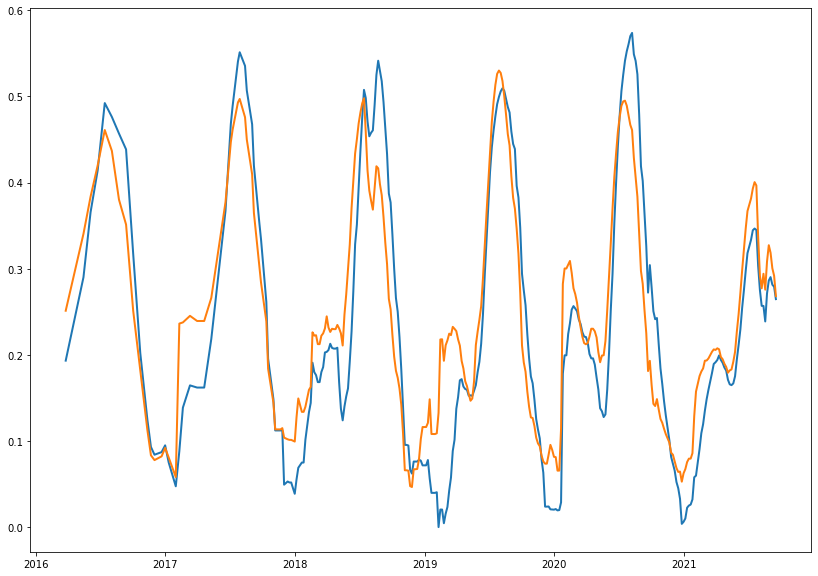

In [39]:
ylabs = ['NDVI']

fig, axs = plt.subplots(1, 1, figsize=(14, 10))


axs.plot(group_dates, ndvi_vals, linewidth=2.0)
axs.plot(group_dates, ndvi_vals_all, linewidth=2.0)

In [40]:
# Save these lists to text files for further processing
with open('texts/ndvi_dates.txt', 'w') as f:
    for item in group_dates:
        f.write("%s\n" % item)

with open('texts/ndvi_vals.txt', 'w') as f:
    for item in ndvi_vals:
        f.write("%s\n" % item)